# Here I show implementation of the calculation of quantum price levels from Lee's 2020 Quantum Finance book.
## We will use daily OHLCV data to predict future s&p500 (SPY) returns.

In [1]:

# NOTEBOOK RAN ON 06-04-2023 AFTER MARKET CLOSE

# DEPENDENCIES

#!pip install plotly
#!pip install yfinance
#!pip install pandas
#!pip install numpy

# IMPORTS

from plotly.subplots import make_subplots

import plotly.graph_objects as go
import matplotlib.pyplot as plt

import yfinance
import pandas
import numpy

# GATHER DATA FROM YAHOO FINANCE

#start_date = '2020-01-01'
#end_date = '2022-01-01'
ticker = 'SPY'

daily_stock_data = yfinance.download(ticker) # yf.download(ticker, start_date, end_date)

print(daily_stock_data)


[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1993-01-29   43.968750   43.968750   43.750000   43.937500   25.122343   
1993-02-01   43.968750   44.250000   43.968750   44.250000   25.301027   
1993-02-02   44.218750   44.375000   44.125000   44.343750   25.354626   
1993-02-03   44.406250   44.843750   44.375000   44.812500   25.622644   
1993-02-04   44.968750   45.093750   44.468750   45.000000   25.729855   
...                ...         ...         ...         ...         ...   
2023-05-26  415.329987  420.769989  415.250000  420.019989  420.019989   
2023-05-30  422.029999  422.579987  418.739990  420.179993  420.179993   
2023-05-31  418.279999  419.220001  416.220001  417.850006  417.850006   
2023-06-01  418.089996  422.920013  416.790009  421.820007  421.820007   
2023-06-02  424.500000  428.739990  423.950

# Chapter 3
## Using relative return instead of price (Equ 3.8 from book).
# &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$r(t,\Delta t)=\frac{p(t)}{p(t-\Delta t)}-1$
## Where $\Delta t$ is the time difference between adjacent timestamps and $p(t)$ is the closing price at the end of the market day (4pm EST on date $t$). In our example, $\Delta t$ = 1 day.

In [2]:

daily_stock_data['r'] = daily_stock_data['Adj Close'] / daily_stock_data['Adj Close'].shift(1) - 1
daily_stock_data = daily_stock_data.iloc[1:]

print(daily_stock_data['r'])


Date
1993-02-01    0.007113
1993-02-02    0.002118
1993-02-03    0.010571
1993-02-04    0.004184
1993-02-05   -0.000695
                ...   
2023-05-26    0.012951
2023-05-30    0.000381
2023-05-31   -0.005545
2023-06-01    0.009501
2023-06-02    0.014461
Name: r, Length: 7640, dtype: float64


# Chapter 4
## Lee derieved an equation of motion by quantifying the effect of the major market participants and arrived at the schrodinger equation for an aharmonic oscillator. The eigenenergies are used as the quantum price levels.
# Chapter 5
## In efficient and stationary markets, the probability density $|\psi(r,t)|^2$ of price returns $r(t,\Delta t)$ should behave as a normal distribution.
# &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$|\psi(r,t)|^2 = |\psi(r)|^2 = \rho (r)$
## Three things to note about $\rho (r)$: the data should fall into a normal distribution, the mean is close to zero, and the ground state wave function $\psi(r)$ is symmetric around zero.
## We discard returns that are further away that 3 standard deviations ($3\sigma$) away from the mean. That means that the width $\Delta x$ of each bin we use for our probability density will be $\Delta x=\frac{2s\sigma}{b}$ where $b$ is the number of bins we have and $s$ is the number of standard deviations we allow the values of $r$ to be within. In our case, we use 100 bins which means $\Delta x=\frac{3\sigma}{50}$, and we use 2048 days as the lookback period as used in the book.

AVERAGE DAILY RETURN: 0.0004783440163022054
STANDARD DEVIATION OF DAILY RETURN: 0.011726645670740877


0.9936849925705795

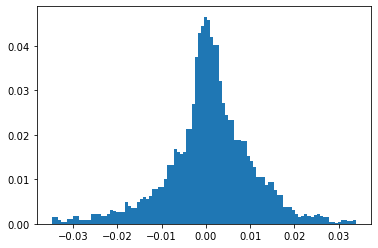

In [3]:

stds = 3
bins = 100
lookback = 2048
start = 2

# using the past 2048 days as in the book (for a different security)
past_observations = daily_stock_data['r'].iloc[-start-lookback:-start]

mean = past_observations.mean()
std = past_observations.std()

print('AVERAGE DAILY RETURN:', mean)
print('STANDARD DEVIATION OF DAILY RETURN:', std)

# exclude all returns higher than 3 standard deviations away from the mean
past_observations_in_range = past_observations[(past_observations-mean)**2 <= (stds*std)**2]

# group the returns in bins by their deviations away from the mean
# divide the number of occurrences in each bin by their sum
probability_density_array = pandas.cut(past_observations_in_range,bins=bins).value_counts(normalize=True,sort=False)

r_min = probability_density_array.index.min().left # lowest return value in the array
r_max = probability_density_array.index.max().right # highest return value in the array

pp = lambda r : probability_density_array.iloc[int((bins-1) * (min(max(r,r_min),r_max)-r_min) / (r_max-r_min))]

def p(r):
    
    binu = lambda off : min(max(0,int((bins-1) * (min(max(r,r_min),r_max)-r_min) / (r_max-r_min))+off),bins-1)
    pda = probability_density_array.iloc
    
    # use equation 5.18c to find the probability density
    return 0.25 * (pda[binu(-1)] + pda[binu(1)] + 2*pda[binu(0)])

x = numpy.arange(bins)/(bins-1) * (r_max - r_min) + r_min

plt.bar(x, numpy.vectorize(p)(x), 1.01 * (r_max - r_min) / (bins - 1)) # the probability density function

numpy.vectorize(p)(x).sum()

## &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$K_0\approx\left[\frac{1.1924 \space + \space 33.2383n \space + \space 56.2169n^2}{1 \space + \space 43.6196n}\right]^{1/3}$
## The finite difference methods used in the book are equations 5.18a, b, and c. We will only use 5.18c which is presented below.
## &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $f''(x)\approx\frac{f(x \space - \space \Delta x) \space - \space 2f(x) \space + \space f(x \space + \space \Delta x)}{\Delta x^2}$
## Now we will solve $\lambda$ in the quantum finance shrodinger equation (QFSE) (equation 5.15) derived in the book.
## &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\frac{d^2\psi (r)}{dr^2} \space + \space \left(r^2 \space + \space \lambda r^4\right ) \psi (r) = E\psi (r)$
## We will obtain $\lambda$ using a slightly different method than the book; first we evaluate the QFSE at $r=0$ using equation 5.18c. This will give us the ground state energy. Then we can use the formula below (equation 5.16) to find $\lambda$ where $n=0$.
## &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\left(\frac{E_n}{2n \space + \space 1}\right )^3 \space - \space \left(\frac{E_n}{2n \space + \space 1}\right ) \space - \space K_0^3\lambda = 0$
## Our final equation for $\lambda$ ends up being the equation below.
## &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\lambda = \frac{E_0^3 \space - \space E_0}{1.1924}$ &emsp;where&emsp; $E_0 = \frac{\psi(-\frac{3\sigma}{50}) \space + \space \psi(\frac{3\sigma}{50})}{\left(\frac{3\sigma}{50} \right )^2\psi(0)} - \frac{2}{\left(\frac{3\sigma}{50} \right )^2}$
## $E_n$ can be found using a method to find cubic roots which is discussed in the book. Using $c_0 = -K_0^3\lambda$ and $c_1 = \sqrt{\frac{c_0^2}{4} \space - \space \frac{1}{27}}$, $E_n$ can be expressed as the equation below.
## &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $E_n = \left(2n \space + \space 1 \right)\left[\left(c_1 \space - \space \frac{c_0}{2} \right)^{1/3} \space - \space \left(c_1 \space + \space \frac{c_0}{2} \right)^{1/3}\right]$
## Our formula for quantum price levels is $Q_n=P\left(1 \space \pm \space \frac{0.21\sigma E_n}{E_0} \right)$ where $P$ is chosen to be the last available daily closing price.

In [4]:

k = lambda n : ((1.1924 + 33.2383*n + 56.2169*n*n) / (1 + 43.6196*n))**(1/3)

dx = 2*stds*std/bins

E0 = ((p(-dx) + p(dx)) / p(0) - 2) / dx / dx

l = (E0**3 - E0) / 1.1924 # lambda

def E(n):
    
    nn = n if n >= 0 else -n
    
    c0 = -k(nn)**3*l
    c1 = (c0**2/4-1/27)**0.5
    
    E = (2*nn+1)*((c1-c0/2)**(1/3)-(c1+c0/2)**(1/3)) / E0
    EE = E if n >= 0 else -E
    
    return 1 + std * 0.21 * EE

nqprs = numpy.vectorize(E)(numpy.arange(101)-50)


## Plot the 8 nearest price levels to the last 1-minute close on an intraday chart.

In [5]:

intraday_lookback = 1

intraday_stock_data = yfinance.download(ticker,interval='1m',start=daily_stock_data.index[-intraday_lookback],
                                        period=f'{intraday_lookback}d',prepost=True)


[*********************100%***********************]  1 of 1 completed


In [7]:

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1, subplot_titles=('OHLC', 'Volume'),
                    row_width=[0.3, 0.7])

fig.add_trace(go.Candlestick(x=intraday_stock_data.index, open=intraday_stock_data['Open'],
                                     high=intraday_stock_data['High'], low=intraday_stock_data['Low'],
                                     close=intraday_stock_data['Close'], showlegend=False), row=1, col=1)

fig.add_trace(go.Bar(x=intraday_stock_data.index, y=intraday_stock_data['Volume'], showlegend=False), row=2, col=1)

fig.update_layout(title="Daily OHLCV", yaxis_title="Price (USD)", width=900, height=600)
fig.update(layout_xaxis_rangeslider_visible=False)

qpls = nqprs * daily_stock_data['Adj Close'].iloc[-intraday_lookback-1]
qpls = list(zip(list(((qpls-intraday_stock_data['Adj Close'].iloc[-1])**2)**0.5),list(qpls)))

qpls.sort()

rx = [intraday_stock_data.index[0],intraday_stock_data.index[-1]]

qplc = {'color':'rgba(64,64,255,0.5)'}

# plot the 8 closest qpls to the current intraday price
for i in qpls[:8]: fig.add_trace(go.Line(x=rx,y=2*[i[1]],showlegend=False,line=qplc),row=1,col=1)

fig.show()
